# main

True circle:  (199, 145) 19
prediction:  (198, 146) 20


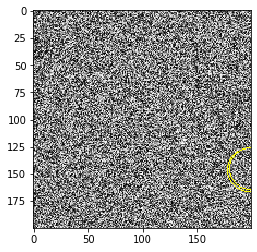

iou =  0.8898558326044305
True circle:  (193, 1) 47
prediction:  (172, 24) 35


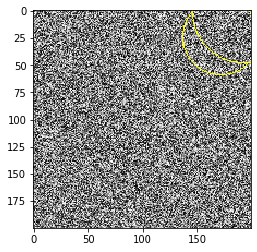

iou =  0.33314843194337573
iou mean =  0.5


In [67]:
import numpy as np
from shapely.geometry.point import Point
from skimage.draw import circle_perimeter_aa
import matplotlib.pyplot as plt
import cv2
from PIL import Image


def draw_circle(img, row, col, rad):
    rr, cc, val = circle_perimeter_aa(row, col, rad)
    valid = (
        (rr >= 0) &
        (rr < img.shape[0]) &
        (cc >= 0) &
        (cc < img.shape[1])
    )
    img[rr[valid], cc[valid]] = val[valid]


def noisy_circle(size, radius, noise):
    img = np.zeros((size, size), dtype=np.float)

    # Circle
    row = np.random.randint(size)
    col = np.random.randint(size)
    rad = np.random.randint(10, max(10, radius))
    draw_circle(img, row, col, rad)

    noisy_img = img.copy()

    # Noise
    noisy_img += noise * np.random.rand(*img.shape)
    return (row, col, rad), noisy_img, img


def find_circle(img,mask):
    # Fill in this function
    noisy_img = [transform(img)]
    mask_img = [transform(mask)]
    size = 1

    test_data = MyDataset(noisy_img, mask_img, size)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=1)

    find_circle_net = UNet()
    if torch.cuda.is_available():
        find_circle_net = find_circle_net.cuda()
    find_circle_net.load_state_dict(torch.load("./drive/My Drive/csc420/q2_net_dice_1000_15.pt"))

    test_result = test(find_circle_net, testloader)
    center, radius = detect_circle(test_result[0][0].cpu().squeeze().detach().numpy())
    print("prediction: ", center, radius)
    # print("==================================================================================================")
    return center[1], center[0], radius


def iou(params0, params1):
    row0, col0, rad0 = params0
    row1, col1, rad1 = params1

    shape0 = Point(row0, col0).buffer(rad0)
    shape1 = Point(row1, col1).buffer(rad1)

    return (
        shape0.intersection(shape1).area /
        shape0.union(shape1).area
    )


def main():
    results = []
    for _ in range(2):
        params, noisy_img, mask = noisy_circle(200, 50, 2)
        print("==================================================================================================")
        print("True circle: ", (params[1], params[0]), params[2])
        detected = find_circle(noisy_img, mask)
        seg = vis(detected, noisy_img, params)
        plt.imshow(seg, cmap="gray")
        plt.show()
        print("iou = ", iou(params, detected))
        print("==================================================================================================")
        results.append(iou(params, detected))
    results = np.array(results)
    print("iou mean = ", (results > 0.7).mean()) 

main()

# Mount Data

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# visualize

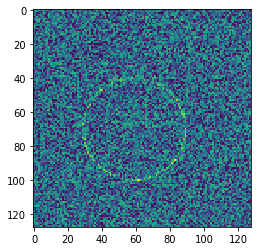

In [64]:
noisy_params, noisy_img, mask_img = noisy_circle(128, 50, 2)
plt.imshow(noisy_img)
noisy_img = noisy_img * 255
mask_img = mask_img * 255
cv2.imwrite("./noisy_img.jpg", noisy_img)
cv2.imwrite("./mask_img.jpg", mask_img)

def visualize(result, index):
    plt.subplot(1,4,1)
    plt.imshow(result[index][2].cpu().squeeze(),cmap=plt.cm.binary)
    plt.subplot(1,4,2)
    plt.imshow(result[index][1].cpu().squeeze())
    plt.subplot(1,4,3)
    plt.imshow(result[index][0].cpu().squeeze().detach().numpy(),cmap=plt.cm.binary)

    ret, binary_pred = cv2.threshold(result[index][0].cpu().squeeze().detach().numpy(),0.04,1,0)
    outputs = np.array(binary_pred)*255
    images = np.array(result[index][1].cpu().squeeze())

    result = np.copy(images)
    outputs_canny = cv2.Canny(np.uint8(outputs), 20, 250)
    result[outputs_canny == 255] = [0,1,0]
    plt.subplot(1,4,4)
    plt.imshow(result)
    plt.tight_layout()

def vis(detected, noisy_img, params):
    true_row, true_col, true_radius = params
    row, col, radius = detected
    img_seg = np.dstack([noisy_img*255, noisy_img*255, noisy_img*255]).astype("uint8")
    mask = np.zeros(noisy_img.shape, dtype=np.float)
    draw_circle(mask, row, col, radius)
    draw_circle(mask, true_row, true_col, true_radius)
    img_seg[mask > 0.5] = [255, 255, 0]
    return img_seg

# Read Data

In [0]:
import cv2
from pathlib import Path
import glob
from PIL import Image
import torch
from torchvision import datasets, transforms
import numpy as np
import pdb

transform = transforms.Compose([transforms.ToTensor()])


def load_transform_train_dataset(transform):
    images = []
    masks = []
    size = 0
    while size < 10:
        params, noisy_img, mask_img = noisy_circle(200, 50, 2)
        noisy_img = transform(noisy_img)
        mask_img = transform(mask_img)
        images.append(noisy_img) 
        masks.append(mask_img)
        size = size + 1
    return images, masks, size

def load_transform_test_dataset(transform):
    images = []
    masks = []
    size = 0
    while size < 10:
        params, noisy_img, mask_img = noisy_circle(200, 50, 2)
        noisy_img = transform(noisy_img)
        mask_img = transform(mask_img)
        images.append(noisy_img) 
        masks.append(mask_img)
        size = size + 1
    return images, masks, size

class MyDataset:

    def __init__(self, inputs, masks, size):
        self.inputs = inputs
        self.masks = masks
        self.len = size

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.inputs[idx].float(), self.masks[idx].float()

# train_inputs, train_thres, train_size = load_transform_train_dataset(transform)
# test_inputs, test_thres, test_size = load_transform_test_dataset(transform)

# train_data = MyDataset(train_inputs, train_thres, train_size)
# test_data = MyDataset(test_inputs, test_thres, test_size)

# trainloader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=1)


# Net

In [6]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from scipy import ndimage as nd
from matplotlib.patches import ConnectionPatch
import heapq
from PIL import Image
import argparse
import math
import numpy as np
import numpy.random as npr
import scipy.misc
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib
import matplotlib.pyplot as plt 
from torchsummary import summary
import pdb

class DoubleConv(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(in_ch,out_ch,3,padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(out_ch),
                nn.Conv2d(out_ch,out_ch,3,padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(out_ch)
            )
    def forward(self,x):
        return self.conv(x)
 
 
class UNet(nn.Module):
    def __init__(self,in_ch=1,out_ch=1):
        super(UNet,self).__init__()
        
        self.conv1 = DoubleConv(in_ch,64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = DoubleConv(64,128)
        self.pool2 = nn.MaxPool2d(2)
        
        # self.conv3 = DoubleConv(128,256)
        # self.pool3 = nn.MaxPool2d(2)
        
        # self.conv4 = DoubleConv(256,512)
        # self.pool4 = nn.MaxPool2d(2)
        
        self.conv5 = DoubleConv(128,256)
        
        # self.up6 = nn.ConvTranspose2d(1024,512,2,stride=2)
        # self.conv6 = DoubleConv(1024,512)
        
        # self.up7 = nn.ConvTranspose2d(512,256,2,stride=2)
        # self.conv7 = DoubleConv(512,256)
        
        self.up8 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.conv8 = DoubleConv(256,128)
        
        self.up9 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.conv9 = DoubleConv(128,64)
        
        self.conv10 = nn.Conv2d(64,out_ch,1)
        
    
    def forward(self,x):
        
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        
        # c3 = self.conv3(p2)
        # p3 = self.pool3(c3)
        
        # c4 = self.conv4(p3)
        # p4 = self.pool4(c4)
        
        c5 = self.conv5(p2)
        
        # up_6 = self.up6(c5)
        # merge6 = torch.cat([up_6,c4],dim=1)
        # c6 = self.conv6(merge6)
        
        # up_7 = self.up7(c5)
        # merge7 = torch.cat([up_7,c3],dim=1)
        # c7 = self.conv7(merge7)
        
        up_8 = self.up8(c5)
        merge8 = torch.cat([up_8,c2],dim=1)
        c8 = self.conv8(merge8)
        
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9,c1],dim=1)
        c9 = self.conv9(merge9)
        
        c10 = self.conv10(c9)
        
        out = nn.Sigmoid()(c10)
        return out

model = UNet()
if torch.cuda.is_available():
    model.cuda()
summary(model, (1, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]             640
              ReLU-2         [-1, 64, 200, 200]               0
       BatchNorm2d-3         [-1, 64, 200, 200]             128
            Conv2d-4         [-1, 64, 200, 200]          36,928
              ReLU-5         [-1, 64, 200, 200]               0
       BatchNorm2d-6         [-1, 64, 200, 200]             128
        DoubleConv-7         [-1, 64, 200, 200]               0
         MaxPool2d-8         [-1, 64, 100, 100]               0
            Conv2d-9        [-1, 128, 100, 100]          73,856
             ReLU-10        [-1, 128, 100, 100]               0
      BatchNorm2d-11        [-1, 128, 100, 100]             256
           Conv2d-12        [-1, 128, 100, 100]         147,584
             ReLU-13        [-1, 128, 100, 100]               0
      BatchNorm2d-14        [-1, 128, 1

# Dice Loss

In [0]:
class DiceLoss(nn.Module):
    
    def __init__(self):
        
        super(DiceLoss, self).__init__()

    def forward(self, input, target):

        smooth = 1.0

        iflat = input.view(-1)
        tflat = target.view(-1)
        
        iflat_square = iflat * iflat
        tflat_square = tflat * tflat
        
        intersection = (iflat * tflat).sum()
    
        return 1 - ( (2.0 * intersection + smooth) / (iflat_square.sum() + tflat_square.sum() + smooth) )
    

# IOU Loss

In [0]:
class IOULoss(nn.Module):
    
    def __init__(self):
        
        super(IOULoss, self).__init__()

    def forward(self, input, target):

        smooth = 1.0

        iflat = input.view(-1)
        tflat = target.view(-1)
        
        iflat_square = iflat * iflat
        tflat_square = tflat * tflat
        sum_A = torch.sum(iflat_square)
        sum_B = torch.sum(tflat_square)
        
        intersection = (iflat * tflat).sum()
        union = sum_A + sum_B - intersection
        iou = (intersection + smooth) / (union + smooth)
        return 1 - iou
    

# Loss Function

In [0]:
def loss_function(loss):
    if loss == 'iou':
        IOU_loss = IOULoss()
        return IOU_loss
    elif loss == 'dice':
        dice_loss = DiceLoss()
        return dice_loss

# Train

In [0]:
import sys
import os
from optparse import OptionParser
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch import optim

from tqdm import tqdm

def train(net,
          trainloader,
          epochs=15,
          batch_size=1,
          lr=0.003,
          val_percent=0.05,
          save_cp=True,
          gpu=True,
          img_scale=0.5,
          loss_fun='dice'):

    if torch.cuda.is_available():
        net.cuda()
    
    criterion = loss_function(loss_fun)
    optimizer = torch.optim.Adam(net.parameters())

    
    result = []
    for e in range(epochs):
        net.train()
        running_loss = 0
        for images, labels in tqdm(trainloader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            log_ps = net(images)
            loss = criterion(log_ps, labels)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
            
            result.append([log_ps, images, labels])
        else:
            print(f"Training loss: {running_loss/len(trainloader)}")
            
    return result
  

# Test

In [0]:
import sys
import os
from optparse import OptionParser
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

def test(net, testloader, loss_fun='dice'):

    net.eval()

    accuracy = 0
    result = []
    
    criterion = loss_function(loss_fun)
    
    for images, labels in testloader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        log_ps = net(images)
        loss = criterion(log_ps, labels)
        
        accuracy += 1 - loss
        
        result.append([log_ps, images, labels])

    # print("Test Accuracy: {:.3f}".format(accuracy / len(testloader)))

    return result

# Run

In [141]:
net = UNet()

if torch.cuda.is_available():
    net = net.cuda()

tr_result = train(net, trainloader)
te_result = test(net, testloader)




# test_inputs, test_mask, test_size = load_transform_test_dataset(transform)
# test_data = MyDataset(test_inputs, test_mask, test_size)

# testloader = torch.utils.data.DataLoader(test_data, batch_size=1)

# test_net = UNet()
# if torch.cuda.is_available():
#     test_net = test_net.cuda()
    
# test_net.load_state_dict(torch.load("./drive/My Drive/csc420/q2_net_iou_2000_15.pt"))
# test_result = test(test_net, testloader)

  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.983546793460846


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.9760441780090332


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.9701757431030273


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.9666402041912079


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.9642593860626221


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.9623984396457672


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.9607059359550476


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.9588531255722046


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.9565382897853851


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.9534995853900909


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.951185554265976


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.9478632211685181


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.9453335106372833


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.9424173831939697


100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


Training loss: 0.9396699368953705
Test Accuracy: 0.001


In [0]:
visualize(test_result, 0)

# Detect Circle

In [0]:
import matplotlib.pyplot as plt
import math

def detect_circle(predict):
    # print(np.size(predict,0), np.size(predict,1))
    predict = predict[1:(np.size(predict,0)-1),1:(np.size(predict,1)-1)]
    # print(np.size(predict,0), np.size(predict,1))
    ret, binary = cv2.threshold(predict,0.04,1,0)
    # print(binary)

    circle_indexs = np.where(binary==np.max(binary))
    # print(circle_indexs)

    min_x = circle_indexs[0][0]
    y_index_for_min_x = np.where(circle_indexs[0]==min_x)[0]
    y_for_min_x_array = circle_indexs[1][y_index_for_min_x]
    y_for_min_x = np.mean(y_for_min_x_array)
    # print('min row = ', min_x, y_for_min_x)

    max_x = circle_indexs[0][-1]
    y_index_for_max_x = np.where(circle_indexs[0]==max_x)[0]
    y_for_max_x_array = circle_indexs[1][y_index_for_max_x]
    y_for_max_x = np.mean(y_for_max_x_array)
    # print('max row = ', max_x, y_for_max_x)

    min_y = min(circle_indexs[1])
    x_index_for_min_y = np.where(circle_indexs[1]==min_y)[0]
    x_for_min_y_array = circle_indexs[0][x_index_for_min_y]
    x_for_min_y = np.mean(x_for_min_y_array)
    # print('min col = ', min_y, x_for_min_y)

    max_y = max(circle_indexs[1])
    x_index_for_max_y = np.where(circle_indexs[1]==max_y)[0]
    x_for_max_y_array = circle_indexs[0][x_index_for_max_y]
    x_for_max_y = np.mean(x_for_max_y_array)
    # print('max col = ', max_y, x_for_max_y)

    point_1 = (y_for_min_x, min_x)
    point_2 = (y_for_max_x, max_x)
    point_3 = (min_y, x_for_min_y)
    point_4 = (max_y, x_for_max_y)
    # print(point_1, point_2, point_3, point_4)

    d_x_1 = point_1[0] - point_2[0]
    d_y_1 = point_1[1] - point_2[1]
    d_1 = math.sqrt(d_x_1**2 + d_y_1**2)
    # print("d1 = ", d_1)

    d_x_2 = point_3[0] - point_4[0]
    d_y_2 = point_3[1] - point_4[1]
    d_2 = math.sqrt(d_x_2**2 + d_y_2**2)
    # print("d2 = ", d_2)

    diameter = max(d_1, d_2)
    # print("diameter = ", diameter)
    radius = int(round(max(d_1, d_2)/2))
    # print("radius = ", radius)

    if diameter == d_1:
        x = int(round((point_1[0] + point_2[0] + 2) / 2))
        y = int(round((point_1[1] + point_2[1] + 2) / 2))
        center = (x, y)

    elif diameter == d_2:
        x = int(round((point_3[0] + point_4[0] + 2) / 2))
        y = int(round((point_3[1] + point_4[1] + 2) / 2))
        center = (x, y)

    # print("center = ", center)

    return center, radius

# detect_circle(predict)
# detect_circle(mask)